<a href="https://colab.research.google.com/github/jjayli/my-data-science/blob/main/Retail_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Starter: Retail Data Analytics**
[Kaggle: Retail Data Analytics](https://www.kaggle.com/code/noob2pro/starter-retail-data-analytics-3254885c-f)


**데이터 구성**

1) stores.csv
    Store(매장 번호), Type(매장 유형:A/B/C), Size(매장 면적)
2) sales.csv

    매장 부서 단위의 실제 매출 데이터(2010-02-05 ~ 2012-11-01)
    Store(매장 번호), Dept(부서 번호), Date(날짜), Weekly_Sales(주간 매출), IsHoliday(휴일 여부)

3) features.csv
    매출에 영향을 줄 수 있는 외부 요인 정보
    Store(매장 번호), Date(주 단위 날짜), Temperature(온도), Fuel_Price(기름값),
    MarkDown1~5(프로모션/할인 관련 지표), CPI(소비자물가지수), Unemployment(실업률), IsHoliday(휴일 여부)

@ 주요 과제
  * 할인 이벤트·휴일·외부 경제지표·매장 특성을 고려해야 하는 복합적인 리테일 예측 문제
    - 시계열, 계절성, 프로모션, 대형/소형 비교, 경제지표와 매출 관계 분석
  * 각 매장의 부서별 다음 해 판매량 예측
  * Holiday 주간의 할인 효과 모델링
  * 매출에 가장 큰 영향을 주는 요인을 기반으로 비즈니스 개선 전략



In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import os

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
import pandas as pd
import numpy as np

stores = pd.read_csv("/content/stores data-set.csv")
features = pd.read_csv("/content/Features data set.csv")
sales = pd.read_csv("/content/sales data-set.csv")

In [5]:
# 결측치 확인
stores.isna().sum()
features.isna().sum()
sales.isna().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0


In [6]:
nRow, nCol = stores.shape
print(f'There are {nRow} rows and {nCol} columns')
stores.head()

There are 45 rows and 3 columns


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
# 데이터 확인
nRow, nCol = features.shape
print(f'There are {nRow} rows and {nCol} columns')
features.head()

There are 8190 rows and 12 columns


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [8]:
nRow, nCol = sales.shape
print(f'There are {nRow} rows and {nCol} columns')
sales.head()

There are 421570 rows and 5 columns


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [9]:
# Scatter and density plots, Kunal G 코드 참고
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis=1) # 코드 수정 dropna
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

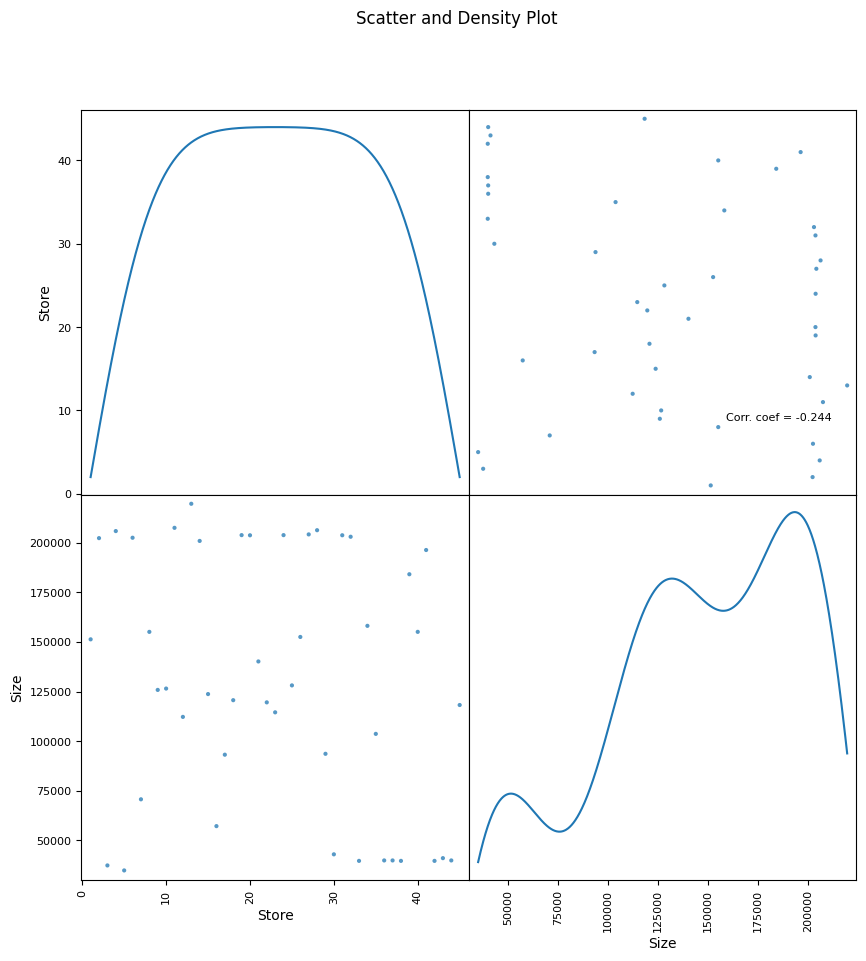

In [10]:
plotScatterMatrix(stores, 10, 8)

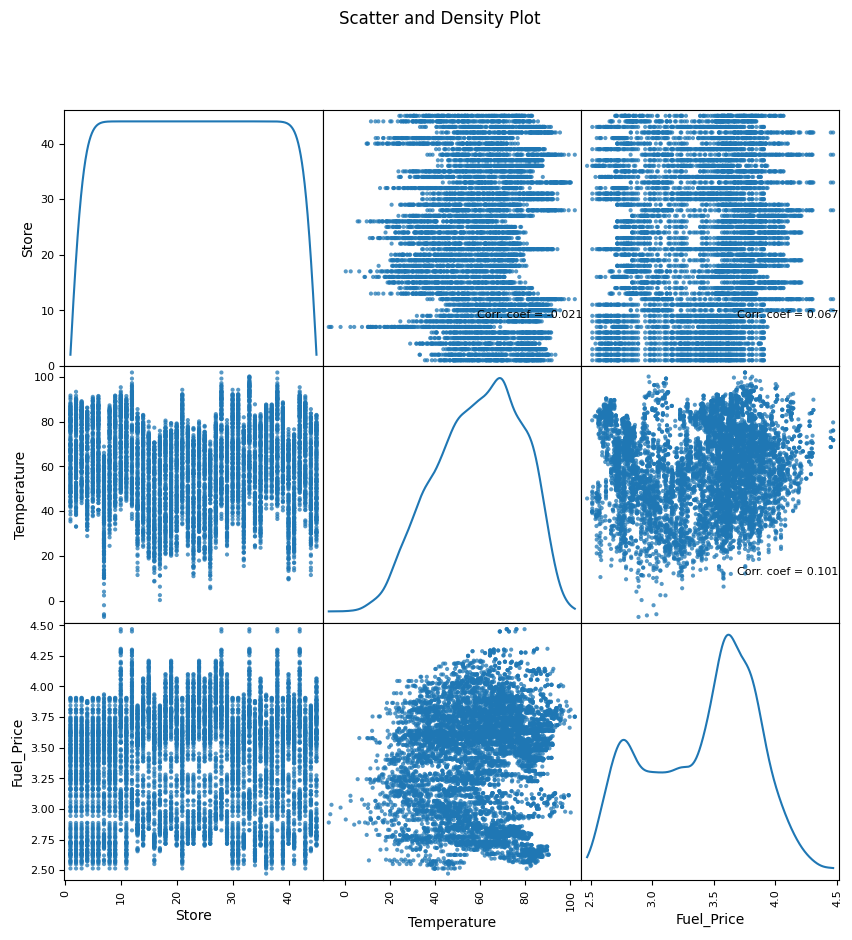

In [11]:
plotScatterMatrix(features, 10, 8)

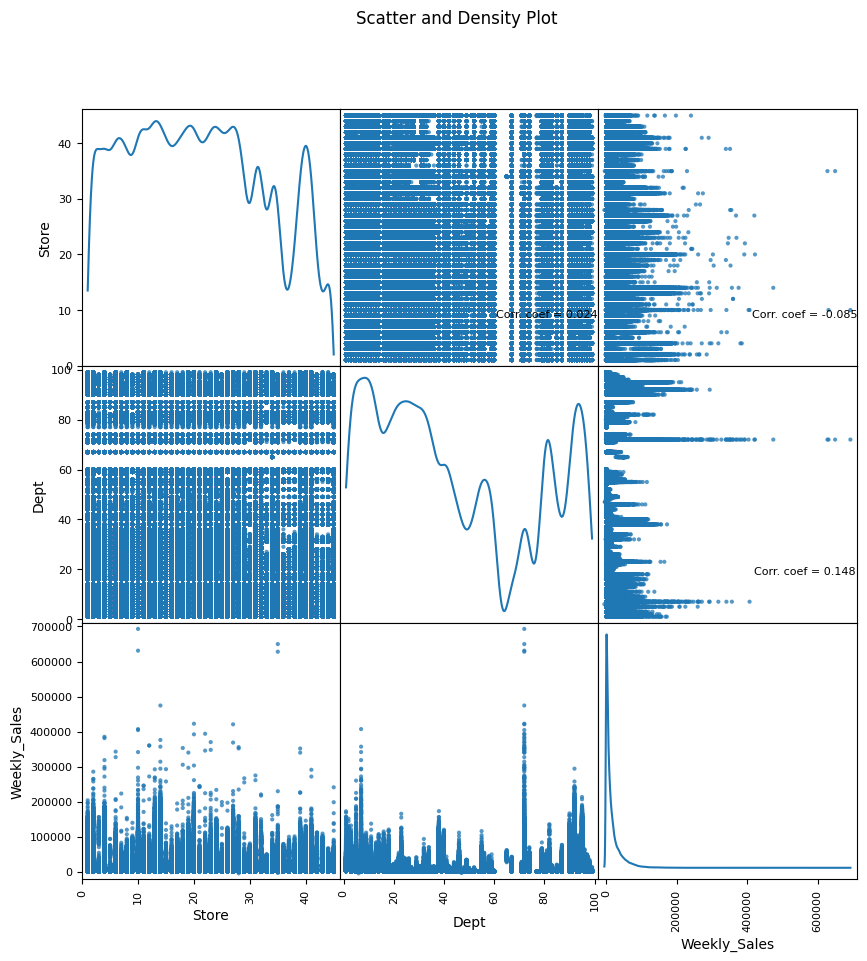

In [12]:
plotScatterMatrix(sales, 10, 8)

데이터 병합

판매 데이터에 매장 정보와 외부 요인을 조인하여 분석 단위 (매장, 날짜)형태로

In [13]:
a = sales.merge(stores, on="Store")
df = a.merge(features, on=["Store", "Date"])

Text(0, 0.5, 'Weekly Sales')

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MA

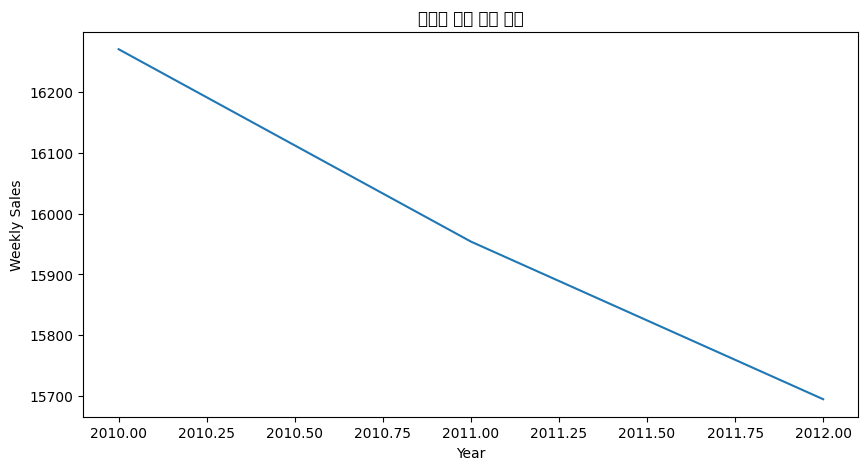

In [14]:
# 트렌드 분석 (시계열 기반) 연간 / 분기별 평균 매출 변화
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

annual_sales = df.groupby('Year')['Weekly_Sales'].mean()

annual_sales.plot(kind='line', figsize=(10,5))
plt.title("연도별 평균 매출 추이")
plt.ylabel("Weekly Sales")


# 특정 연도에 매출이 급감한 구간이 있으며, CPI 및 실업률 변화와 연관될 가능성이 높음
# 월별 패턴을 보면 할인 행사, 시즌성이 뚜렷하게 나타남

<Axes: xlabel='Temperature', ylabel='Weekly_Sales'>

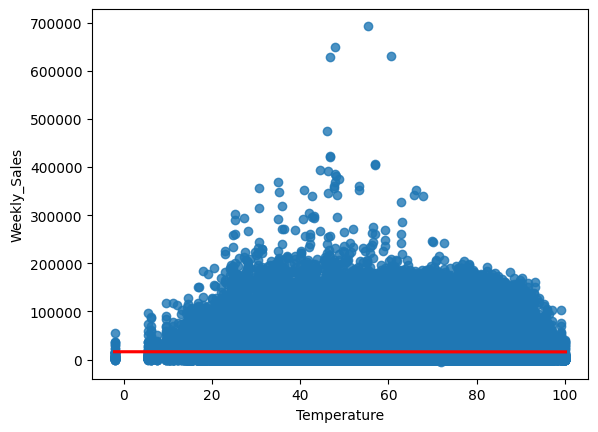

In [15]:
# 온도와 매출
sns.regplot(x='Temperature', y='Weekly_Sales', data=df, line_kws={'color':'red'})

**박스플랏으로 데이터 탐색**

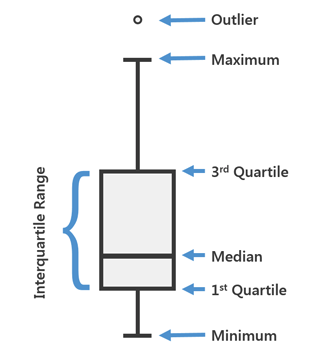

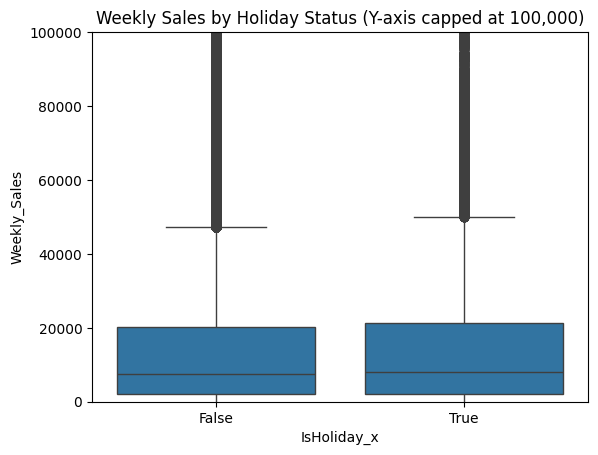

In [18]:
# 연간 날씨 패턴
sns.boxplot(x='IsHoliday_x', y='Weekly_Sales', data=df)
plt.ylim(0, 100000)
plt.title('Weekly Sales by Holiday Status (Y-axis capped at 100,000)')
plt.show()

<Axes: xlabel='Type', ylabel='Weekly_Sales'>

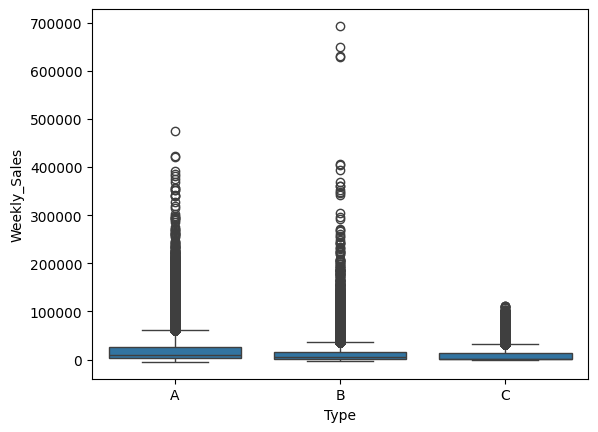

In [17]:
# 매장 타입에 따른 매출 차이
sns.boxplot(data=df, x="Type", y="Weekly_Sales")

# PCA로 중요 변수 선택하기

변수 간 중복정보를 덜어내고 핵심 축을 생성

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

numeric_cols = ['Temperature','Fuel_Price','CPI','Unemployment','Size']
X = StandardScaler().fit_transform(df[numeric_cols])

pca = PCA(n_components=3)
pca.fit(X)

print("설명분산:", pca.explained_variance_ratio_)

#총합 = 0.267 + 0.234 + 0.210 = 약 0.71
#원래 5개 변수를 3개로 줄여도 71% 정보는 보존됨.


설명분산: [0.26701924 0.23350882 0.2103607 ]


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# 예시: features 데이터의 일부 변수 선택
cols = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
X = features[cols]

# NaN 결측치 처리: 평균값으로 대체
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# PCA
pca = PCA(n_components=3)
pca.fit(X_scaled)

# print("설명분산:", pca.explained_variance_ratio_)

loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC1', 'PC2', 'PC3'],
                        index=cols)

loadings

,PC1,PC2,PC3
Temperature,-0.030083,0.896737,-0.042136
Fuel_Price,-0.334900,0.206080,0.845025
CPI,0.713423,0.324076,-0.061407
Unemployment,-0.614788,0.219930,-0.529516


**결과 해석**
PC1: CPI, 실업률 축 → 경제 여건
PC2: 온도 축 → 지역 기후 차이
PC3: 기름값, 실업률 축 → 에너지·고용 환경

